In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
from datetime import datetime, timedelta
import numpy as np

# Set up the plotting style
sns.set(style="whitegrid")

# Load the engineered logs
logs_df = pd.read_csv("/Users/davidstroud/cloud_logs/anomaly_detection/engineered_logs_10000.csv")

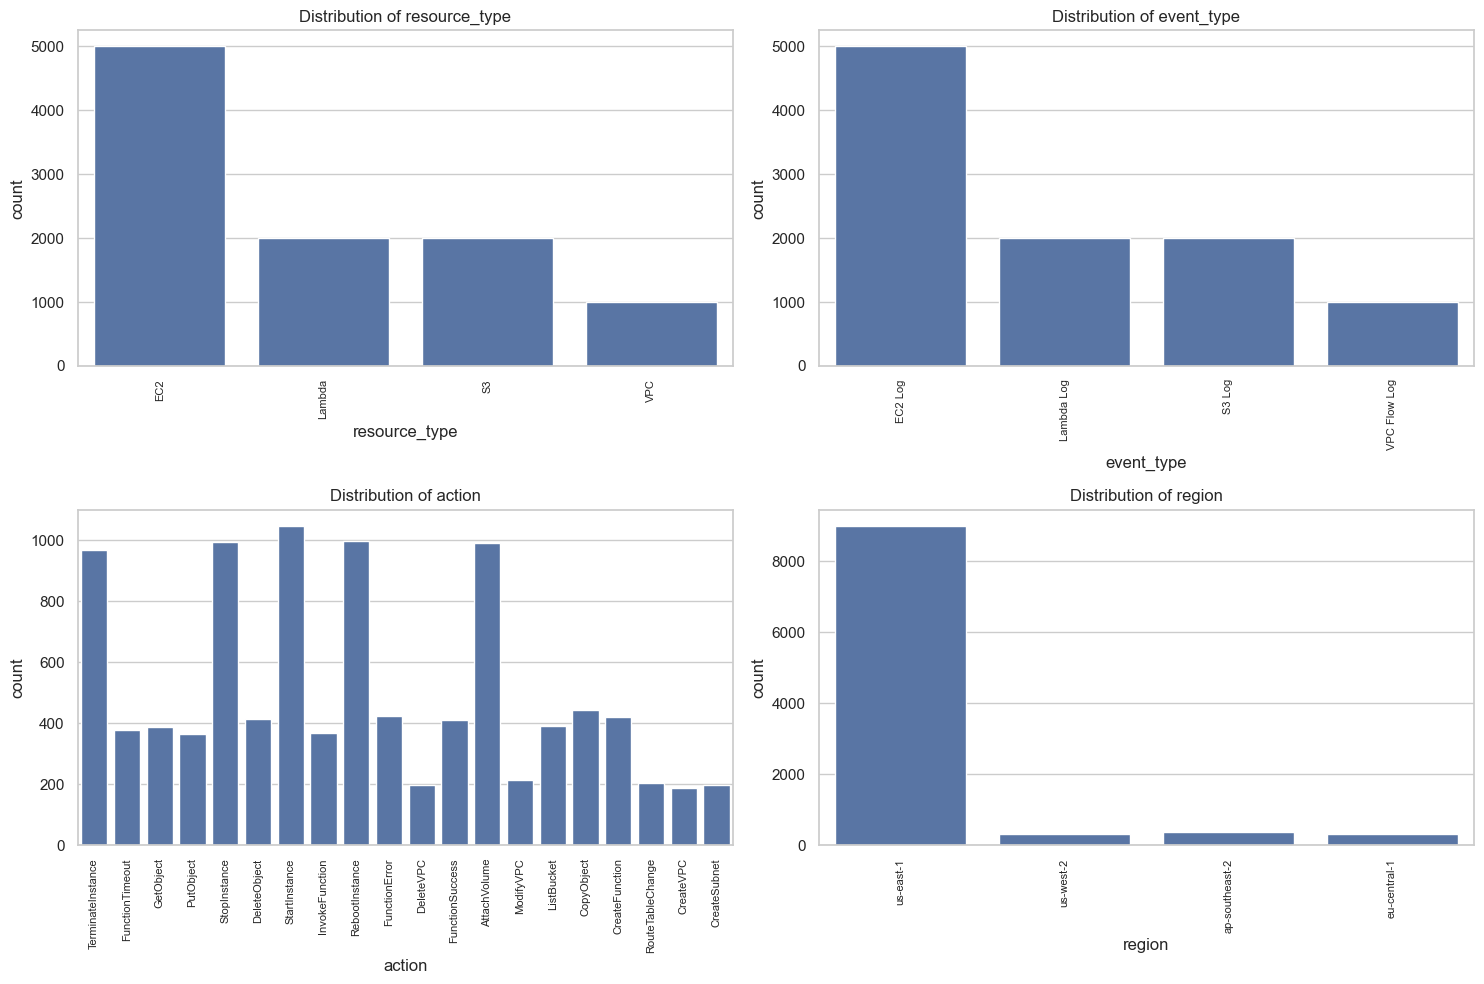

In [2]:
categorical_columns = ['resource_type', 'event_type', 'action', 'region']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for idx, col in enumerate(categorical_columns):
    sns.countplot(data=logs_df, x=col, ax=axes[idx // 2, idx % 2])
    axes[idx // 2, idx % 2].set_title(f'Distribution of {col}')
    
    # Make x-axis labels vertical and adjust font size
    axes[idx // 2, idx % 2].tick_params(axis='x', rotation=90, labelsize=8)
    
    # Optionally, limit the number of unique labels displayed if they are too many
    if len(logs_df[col].unique()) > 20:
        axes[idx // 2, idx % 2].set_xticks([])

plt.tight_layout()
plt.show()

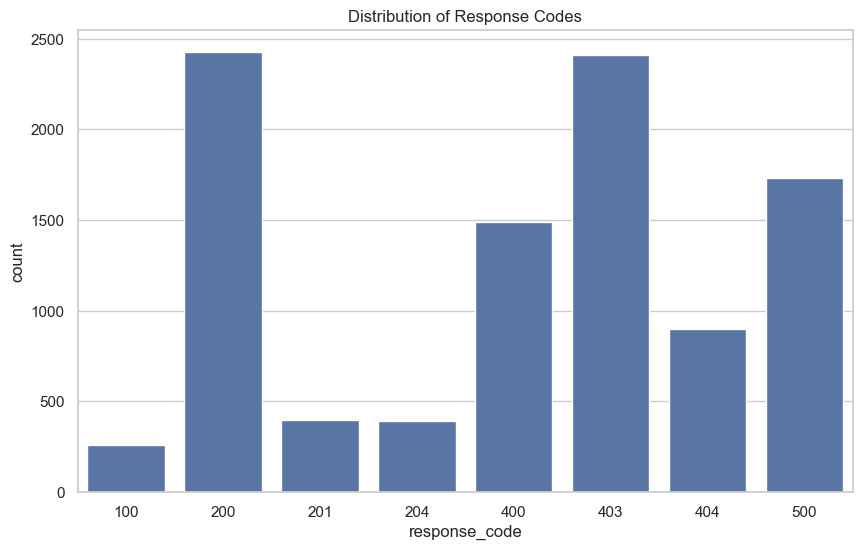

In [3]:
# Response Code Definitions:
# 200: OK - The request was successful.
# 404: Not Found - The server could not find the requested resource.
# 500: Internal Server Error - The server encountered an unexpected condition.

# Analyzing response codes in logs_df

# Count the occurrences of each response code
response_code_counts = logs_df['response_code'].value_counts()

# Plot the distribution of response codes
plt.figure(figsize=(10, 6))
sns.countplot(data=logs_df, x='response_code')
plt.title('Distribution of Response Codes')
plt.show()


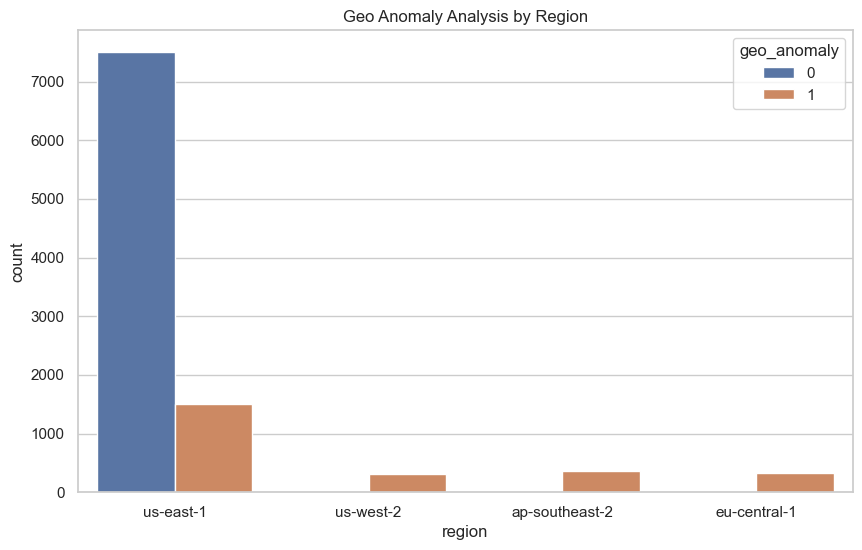

In [4]:
# Plot the distribution of geo anomalies
plt.figure(figsize=(10, 6))
sns.countplot(data=logs_df, x='region', hue='geo_anomaly')
plt.title('Geo Anomaly Analysis by Region')
plt.show()


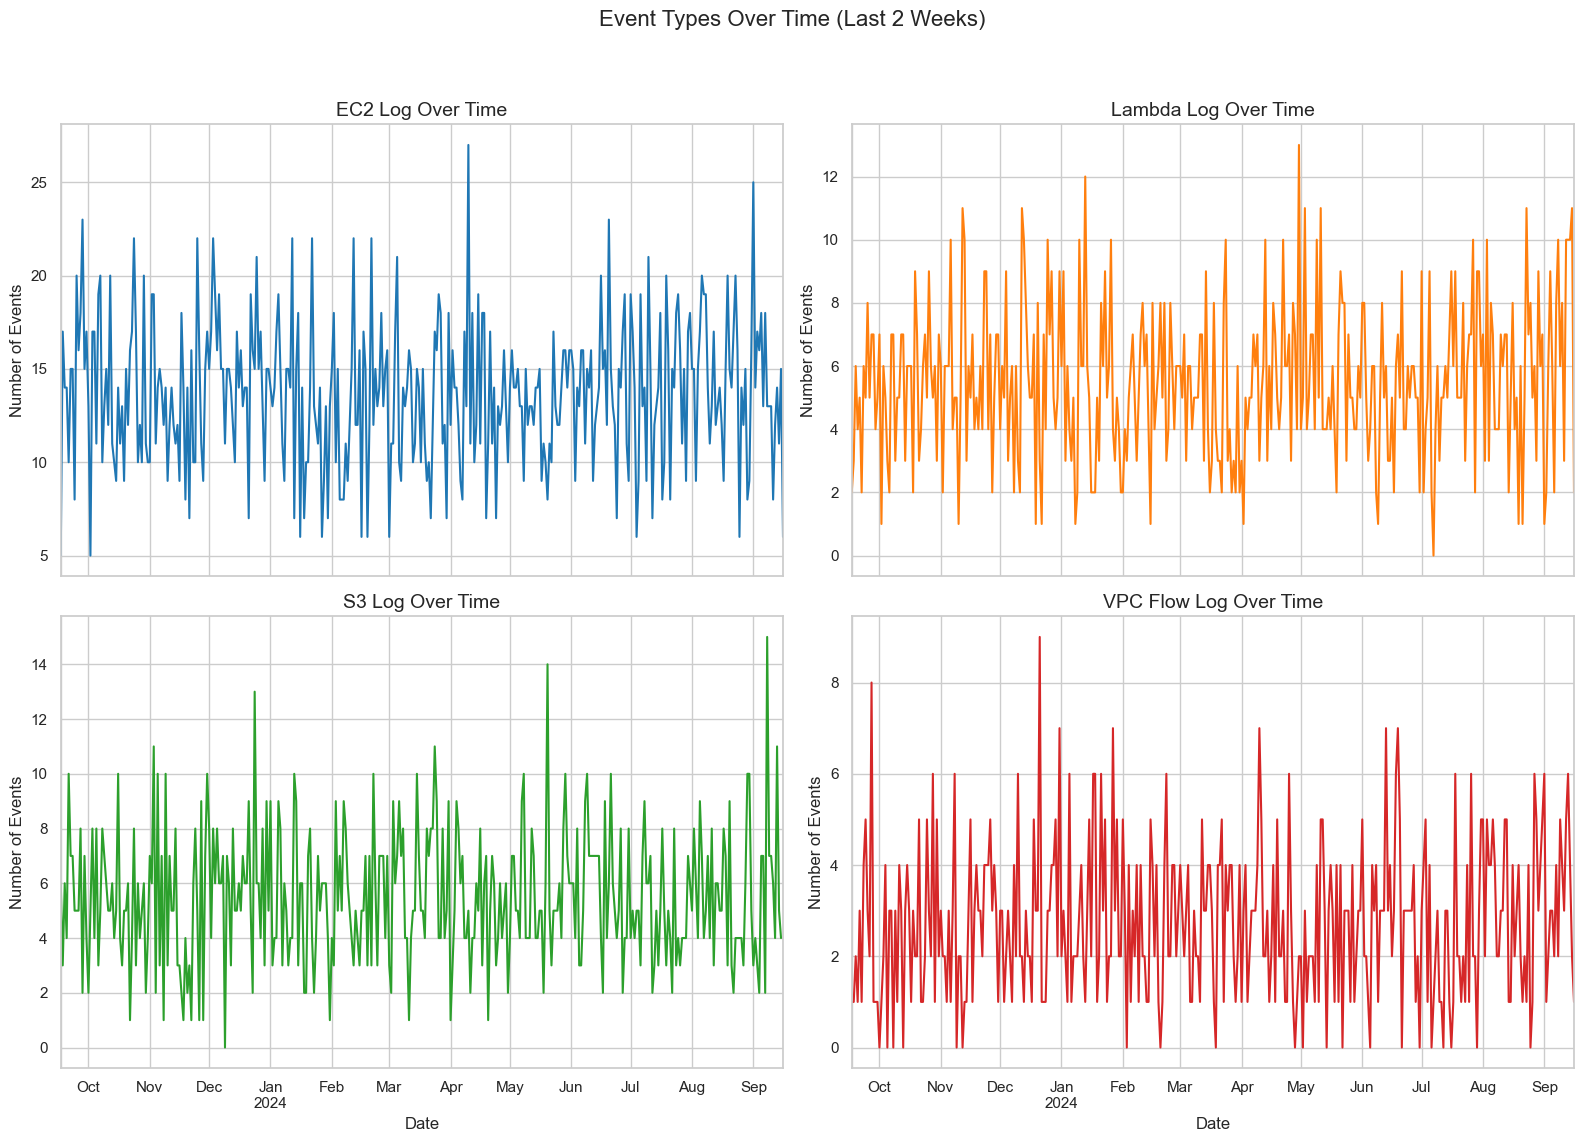

In [16]:
# Assuming logs_df is already defined and contains 'timestamp' and 'event_type' columns

# Convert timestamp to datetime and set it as the index, if not already done
logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'])
logs_df.set_index('timestamp', inplace=True)

# Define event types and colors
unique_event_types = logs_df['event_type'].unique()
colors = sns.color_palette('tab10', len(unique_event_types))  # Distinct colors

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
fig.suptitle('Event Types Over Time (Last 2 Weeks)', fontsize=16)

# Plot each event type separately
for i, event_type in enumerate(unique_event_types):
    ax = axes[i // 2, i % 2]
    event_data = logs_df[logs_df['event_type'] == event_type].resample('D').size()
    event_data.plot(ax=ax, color=colors[i])
    ax.set_title(f'{event_type} Over Time', fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Number of Events', fontsize=12)
    ax.grid(True)

# Improve layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [17]:


# Group by action to count the number of failed actions and geo anomalies
anomalies_by_action = logs_df.groupby('action').agg({
    'failed_action': 'sum',
    'geo_anomaly': 'sum',
    'action_count': 'size'
}).reset_index()

# Calculate the proportion of anomalies for each action
anomalies_by_action['failed_action_rate'] = anomalies_by_action['failed_action'] / anomalies_by_action['action_count']
anomalies_by_action['geo_anomaly_rate'] = anomalies_by_action['geo_anomaly'] / anomalies_by_action['action_count']

# Sort by the rates
anomalies_by_action_sorted = anomalies_by_action.sort_values(by=['failed_action_rate', 'geo_anomaly_rate'], ascending=False)

# Format the rates as percentages and round to two decimal places
anomalies_by_action_sorted['failed_action_rate'] = anomalies_by_action_sorted['failed_action_rate'].apply(lambda x: f"{x:.2%}")
anomalies_by_action_sorted['geo_anomaly_rate'] = anomalies_by_action_sorted['geo_anomaly_rate'].apply(lambda x: f"{x:.2%}")

# Select and display the top 10 actions with the highest anomalies
top_anomalies = anomalies_by_action_sorted.head(10)[['action', 'failed_action', 'geo_anomaly', 'action_count', 'failed_action_rate', 'geo_anomaly_rate']]

print(top_anomalies.to_string(index=False))


          action  failed_action  geo_anomaly  action_count failed_action_rate geo_anomaly_rate
       PutObject            100           97           363             27.55%           26.72%
RouteTableChange             53           53           204             25.98%           25.98%
    DeleteObject            106          102           415             25.54%           24.58%
       GetObject             98          100           386             25.39%           25.91%
    CreateSubnet             50           51           198             25.25%           25.76%
  InvokeFunction             92           96           369             24.93%           26.02%
    AttachVolume            245          235           992             24.70%           23.69%
 FunctionTimeout             93           83           377             24.67%           22.02%
      ListBucket             96           93           392             24.49%           23.72%
   StartInstance            255          256      

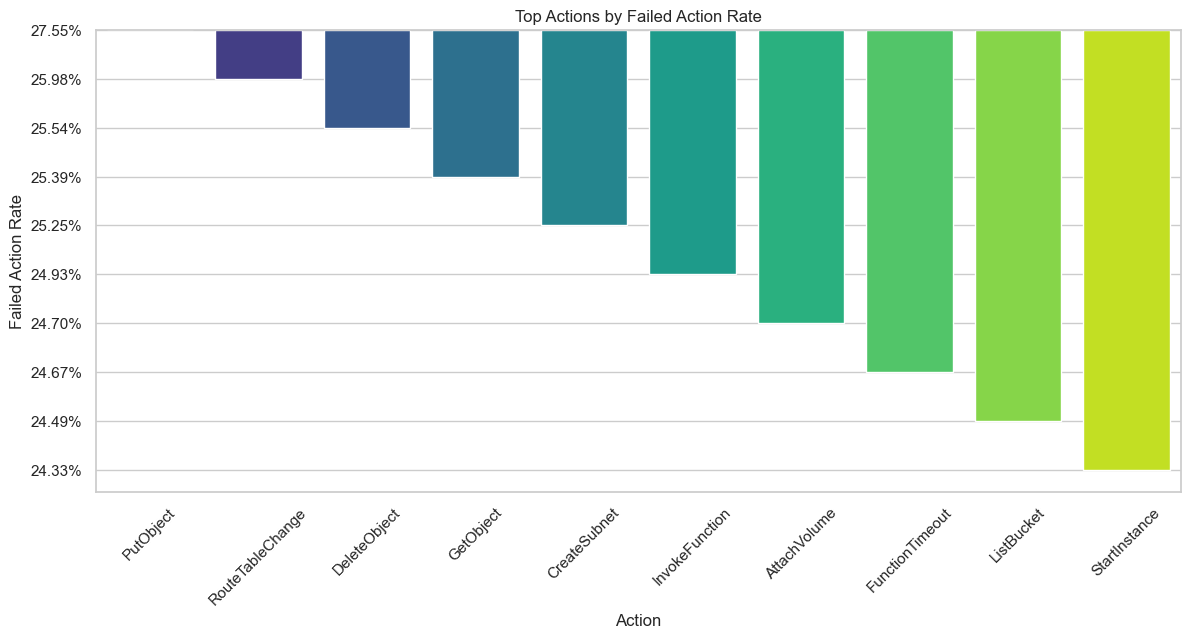

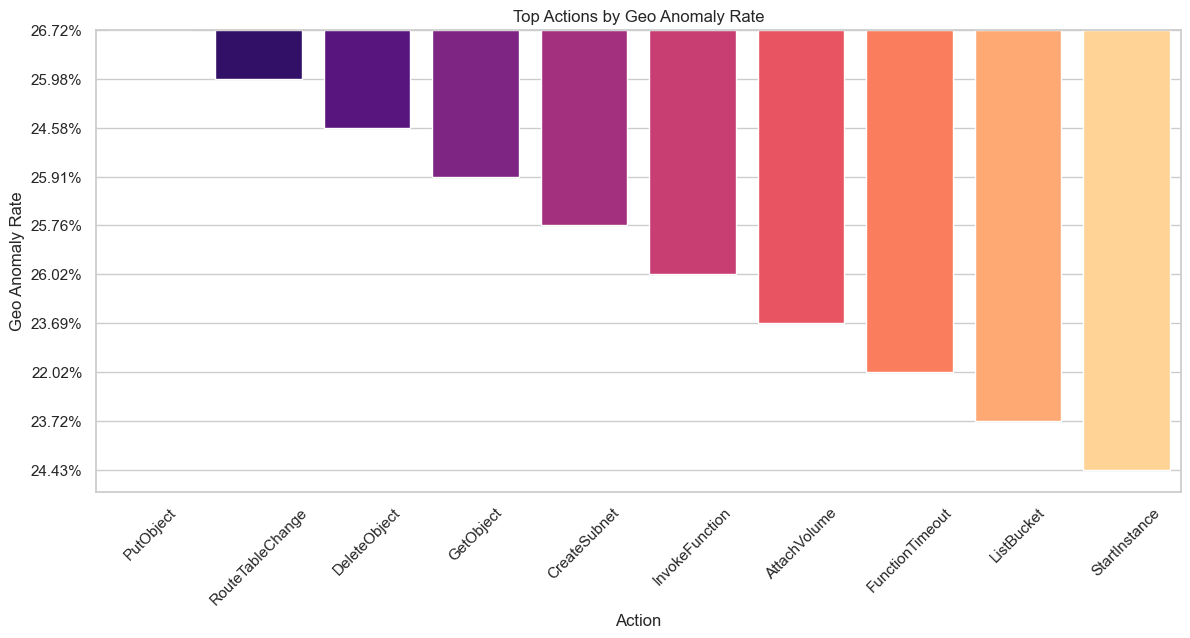

In [18]:
# Define color palettes
failed_action_colors = sns.color_palette('viridis', len(anomalies_by_action_sorted.head(10)))
geo_anomaly_colors = sns.color_palette('magma', len(anomalies_by_action_sorted.head(10)))

# Plotting the top actions with the highest failed action rates
plt.figure(figsize=(14, 6))
sns.barplot(
    x='action', 
    y='failed_action_rate', 
    data=anomalies_by_action_sorted.head(10), 
    color='grey',  # default color
    palette=None
)

# Manually setting colors for each bar
for i, bar in enumerate(plt.gca().containers[0]):
    bar.set_facecolor(failed_action_colors[i])

plt.title('Top Actions by Failed Action Rate')
plt.xlabel('Action')
plt.ylabel('Failed Action Rate')
plt.xticks(rotation=45)
plt.show()

# Plotting the top actions with the highest geo anomaly rates
plt.figure(figsize=(14, 6))
sns.barplot(
    x='action', 
    y='geo_anomaly_rate', 
    data=anomalies_by_action_sorted.head(10), 
    color='grey',  # default color
    palette=None
)

# Manually setting colors for each bar
for i, bar in enumerate(plt.gca().containers[0]):
    bar.set_facecolor(geo_anomaly_colors[i])

plt.title('Top Actions by Geo Anomaly Rate')
plt.xlabel('Action')
plt.ylabel('Geo Anomaly Rate')
plt.xticks(rotation=45)
plt.show()


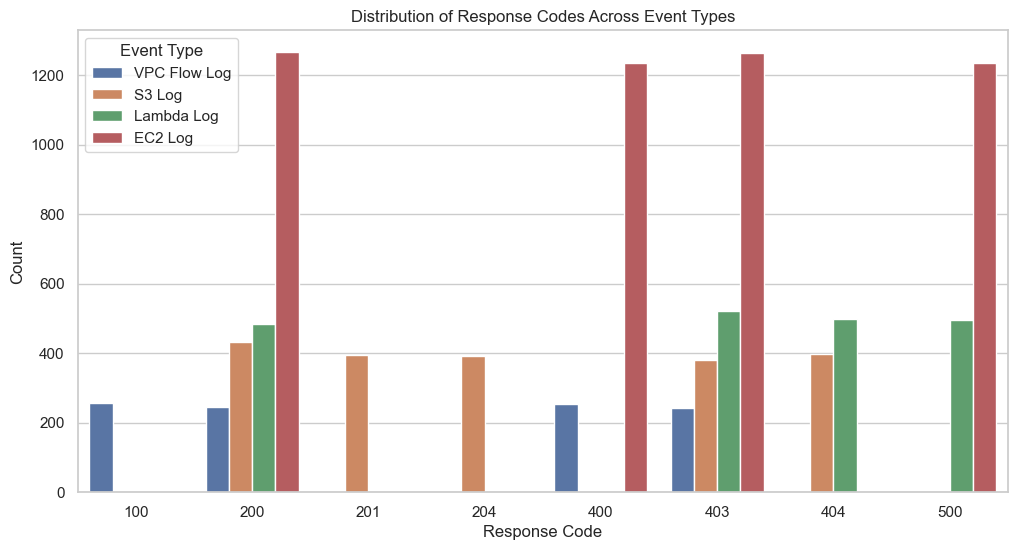

In [20]:
# Distribution of response codes across event types
plt.figure(figsize=(12, 6))
sns.countplot(data=logs_df, x='response_code', hue='event_type')
plt.title('Distribution of Response Codes Across Event Types')
plt.xlabel('Response Code')
plt.ylabel('Count')
plt.legend(title='Event Type')
plt.show()


/var/folders/y0/dn0fm5ms2l171bwrjy3lc8mm0000gn/T/ipykernel_35540/1442709351.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=failure_rate_by_event_type, x='event_type', y='failed_action', palette='coolwarm')


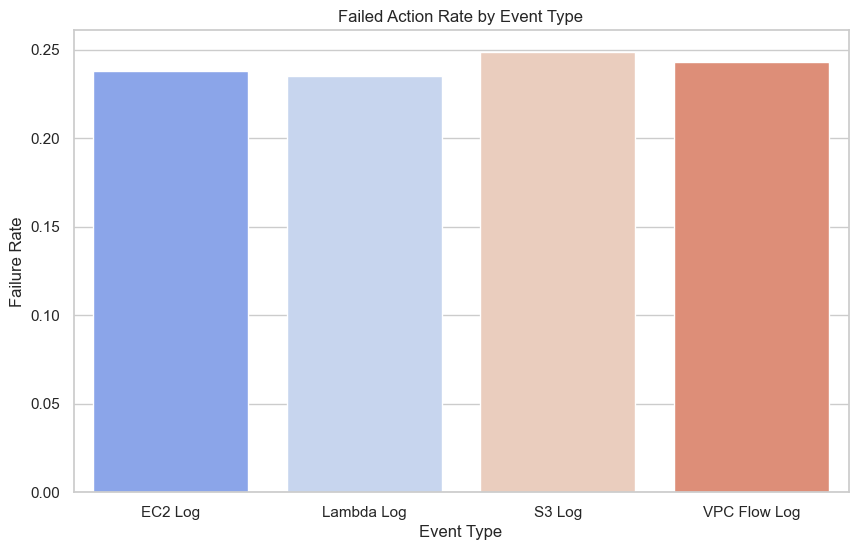

In [21]:
# Calculate the failure rate for each event type
failure_rate_by_event_type = logs_df.groupby('event_type')['failed_action'].mean().reset_index()

# Plot the failure rate for each event type
plt.figure(figsize=(10, 6))
sns.barplot(data=failure_rate_by_event_type, x='event_type', y='failed_action', palette='coolwarm')
plt.title('Failed Action Rate by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Failure Rate')
plt.show()


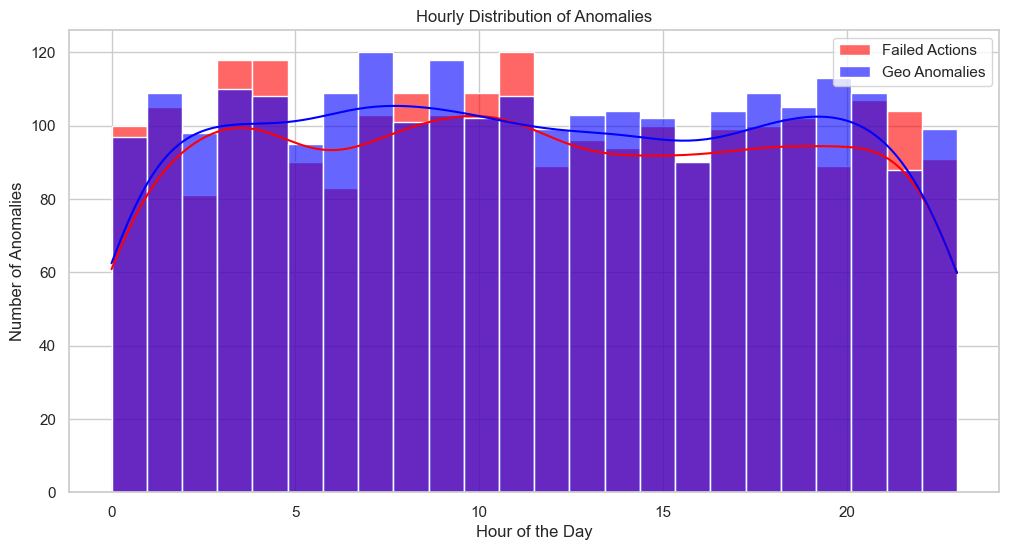

In [22]:
# Analyzing the distribution of anomalies by hour
plt.figure(figsize=(12, 6))
sns.histplot(data=logs_df[logs_df['failed_action'] == 1], x='hour', bins=24, kde=True, color='red', label='Failed Actions', alpha=0.6)
sns.histplot(data=logs_df[logs_df['geo_anomaly'] == 1], x='hour', bins=24, kde=True, color='blue', label='Geo Anomalies', alpha=0.6)
plt.title('Hourly Distribution of Anomalies')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Anomalies')
plt.legend()
plt.show()
